# INTRODUZIONE

<img src="py.jpg" alt="drawing" width="200px"/>

Il codice è stato scritto utilizzando il software open-source *Jupyter Notebook* con kernel *Python3*.

I principali step del programma sono:

<ol>
  <li>**Caricamento dei file DICOM** aggiungendo i metadati mancanti;</li>
  <li>**Conversione dei valori dei pixel in Unita Hounsield (HU)**;</li>
  <li>**Uniformazione del Pixel_Spacing** per rimuovere la viarianza della risoluzione dello scanner;</li>
  <li>**Plot 3D**;</li>
  <li>**Segmentazione dei Polmoni**.</li>
</ol>

In [1]:
%matplotlib inline
import numpy as np  
import pandas as pd # per processing dei dati, CSV file I/O (ad es pd.read_csv)
import pydicom
import os
import time
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#Definisco le costanti
cartella_input = '/home/matteolab/Documents/Progetto_Esame/images/'
pazienti = os.listdir(cartella_input)
pazienti.sort()

# CARICAMENTO DEI FILE

I file sono standard DICOM. Questi file contengono diversi metadati (ad esempio *pixel_size* indica quanto è grande un pixel in ogni dimensione nella realtà).
La grandezza dei pixel varia da scan a scan (quindi la distanza tra le slice può essere diversa). Questo sarà trattato nella parte del resampling dei dati.

Il codice qua sotto permette di caricare gli scan, ognuno composto da più slice. ogni cartella nel dataset è uno scan (un paziente). Manca la grandezza $z$ dei pixel, ma questa si può ricavare facilmente.

A | B
- | - 
![alt](ct.png) | ![alt](ct1.png)

                                    Esempio di due slice di due pazienti differenti


In [2]:
#Carico gli scan
def carica_scan(path): #Sarà: carica_scan(cartella_input + pazienti[n])
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] #Leggo ogni slice
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2])) 

    #Ordino le slice secondo la chiave .ImagePositionPatient[2]
    try:
        larghezza_slice = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2]) 
        #ImagePositionPatient da la posizione x, y e z della slice

    except:
        larghezza_slice = np.abs(slices[0].SliceLocation - slices[1].SliceLocation) 
        #Non tutte le slice sono indicizzate allo stesso modo
        
    for s in slices:
        s.SliceThickness = larghezza_slice #Definisco la larghezza per ogni slice s
    
    return slices

L'unità di misura negli scan TAC è la **Hounsfield Unit (HU)**

![alt](hu.jpg)

Di default però i valori ritornati non sono in questa unità. Per riscalare i dati in unità HU moltiplico i valori dei pixel con la pendenza e l'itercetta di conversione (contenuti nei metadati degli scan)


In [3]:
def conversione_hu(slices): #slices è UN PAZIENTE
    #pixel_array è l'immagine della slice
    image = np.stack([s.pixel_array for s in slices]) 

    #attacca tutti i pixel_array delle diverse slice in un ndarry, ci sarà image[1], image [2] ecc..
    image = image.astype(np.int16) #Converto in int16
    
    # i pixel fuori dallo scan li pongo 0, vista l'intercetta l'aria è approssimativamente 0 dei valori dei pixel
    image[image == -2000] = 0 
    # Converto in Hounsfield units (HU)
    for numero_slice in range(len(slices)): 
        pendenza = slices[numero_slice].RescaleSlope #sono dei metadati DICOM
        intercetta = slices[numero_slice].RescaleIntercept 
        if pendenza != 1:
            image[numero_slice] = pendenza * image[numero_slice].astype(np.float64) 
            #vado a modificare l'array image con i valori esatti riscalati
            image[numero_slice] = image[numero_slice].astype(np.int16)       
        image[numero_slice] += np.int16(intercetta)
    
    return np.array(image, dtype=np.int16)

Guardando un **singolo paziente**:

Paziente # 0 :


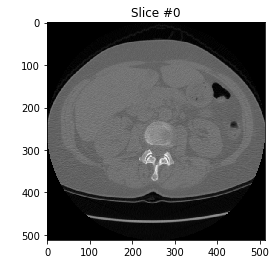

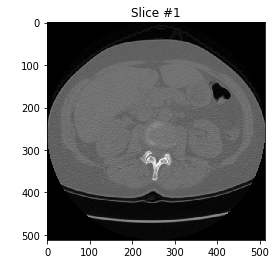

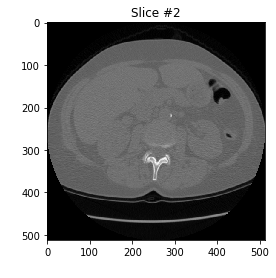

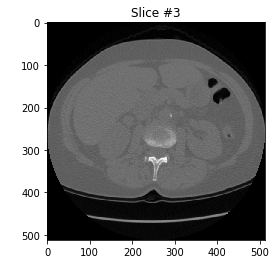

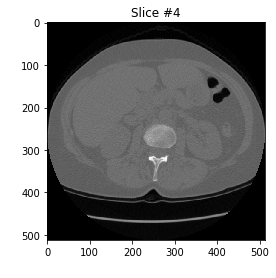

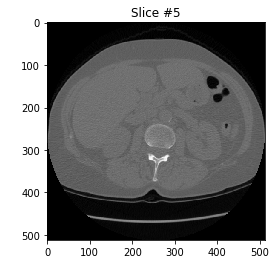

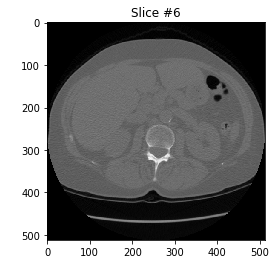

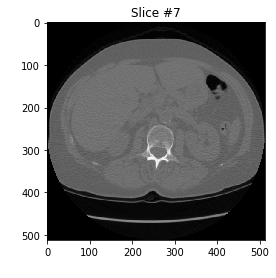

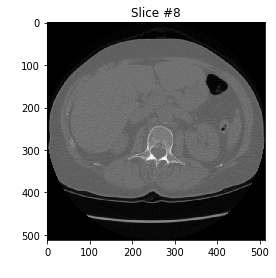

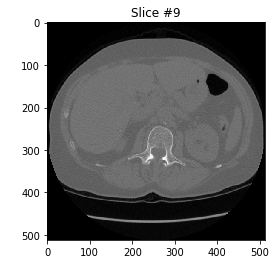

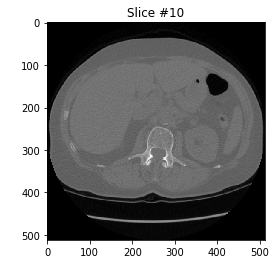

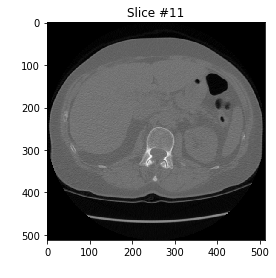

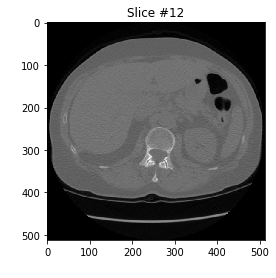

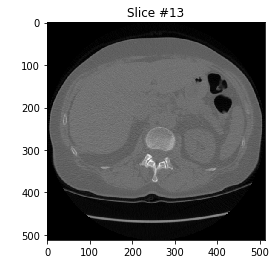

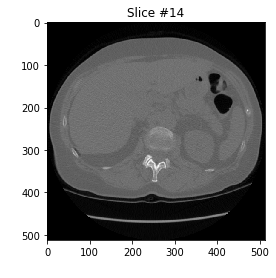

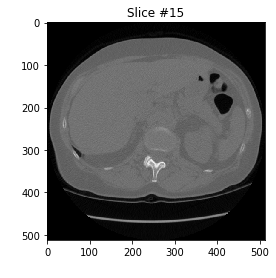

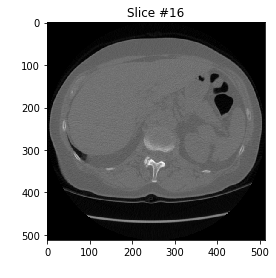

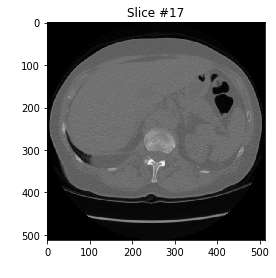

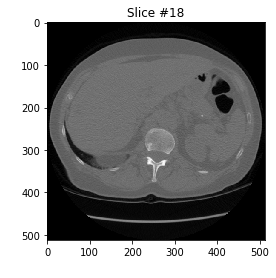

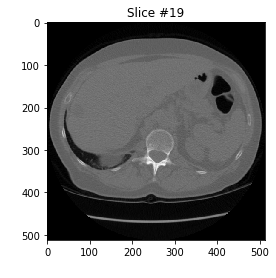

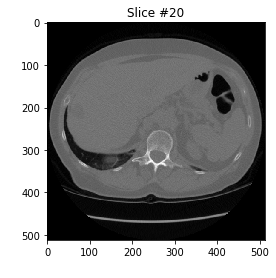

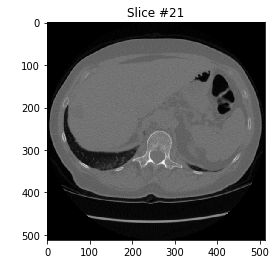

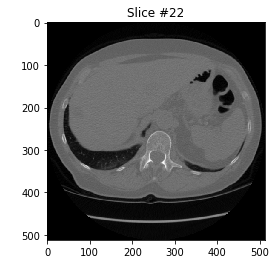

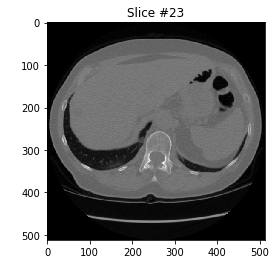

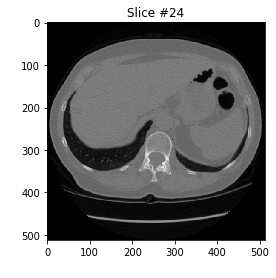

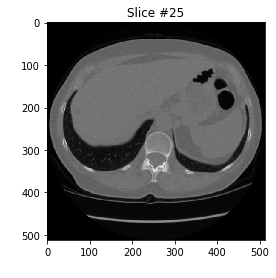

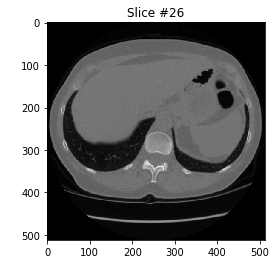

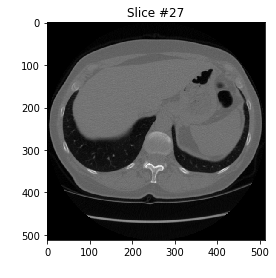

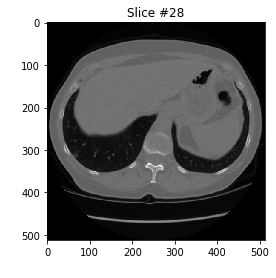

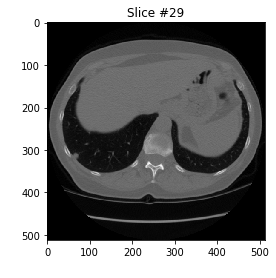

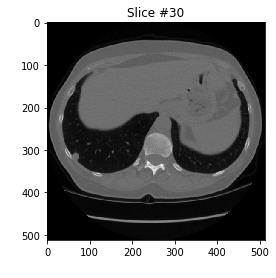

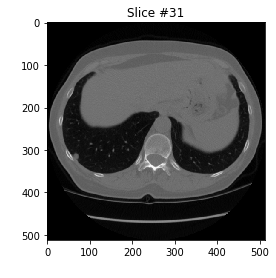

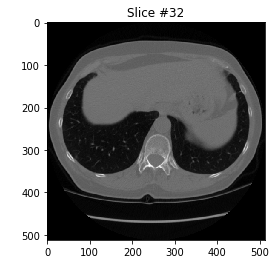

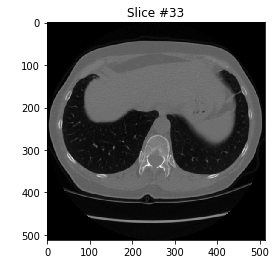

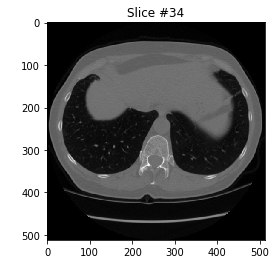

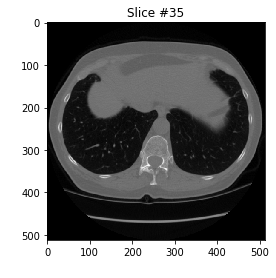

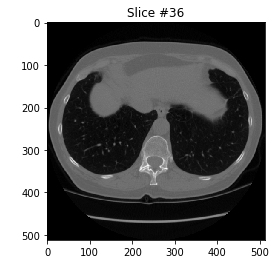

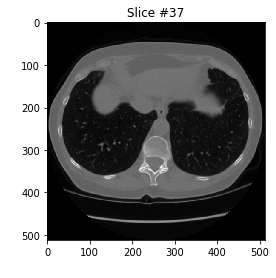

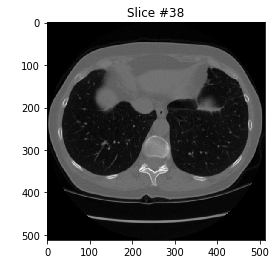

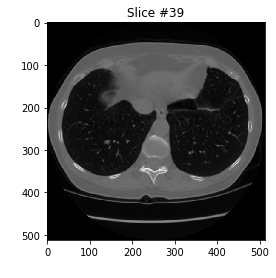

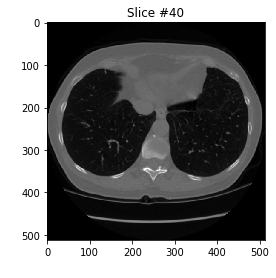

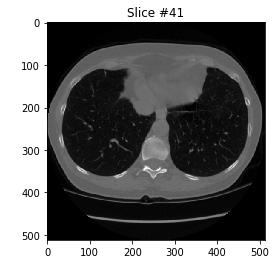

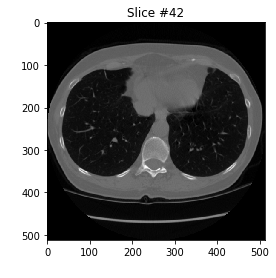

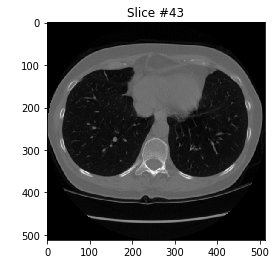

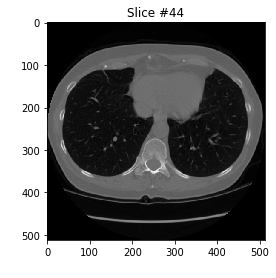

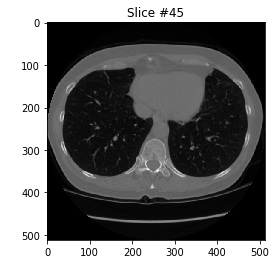

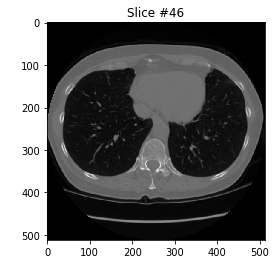

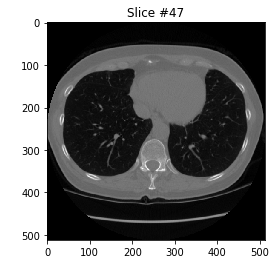

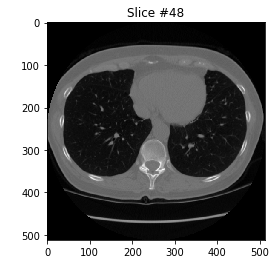

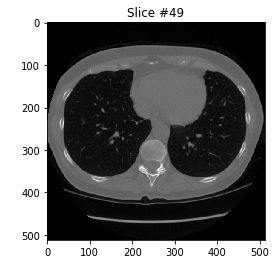

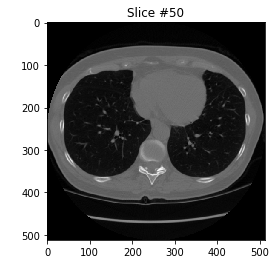

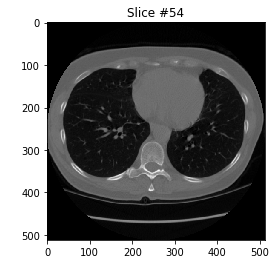

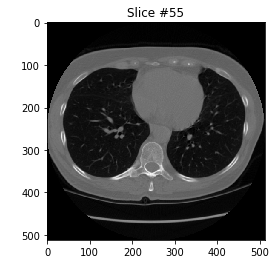

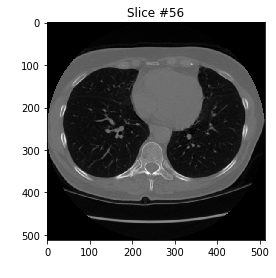

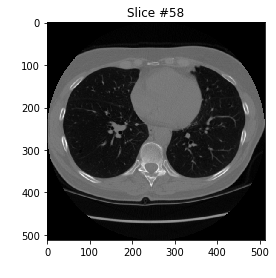

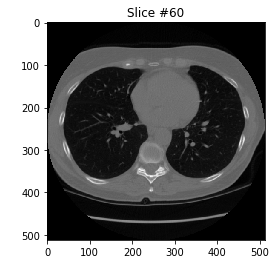

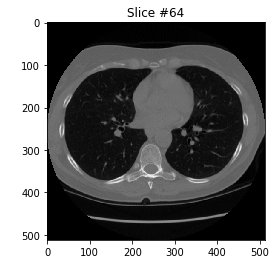

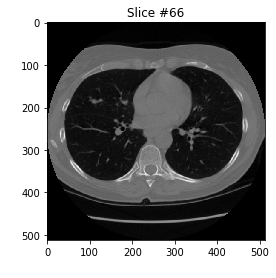

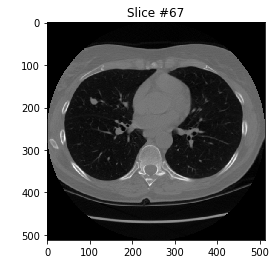

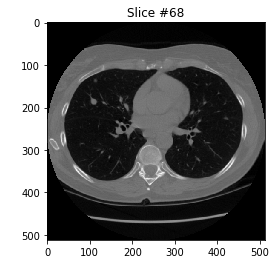

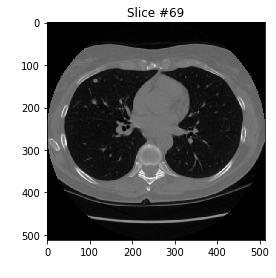

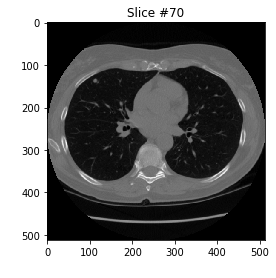

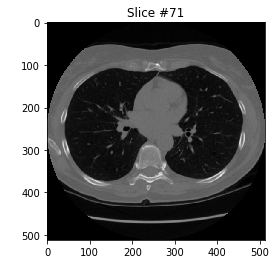

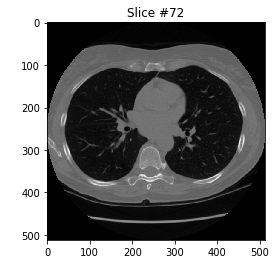

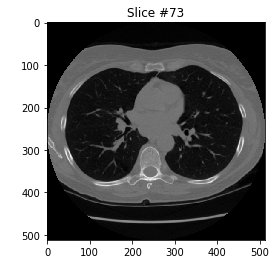

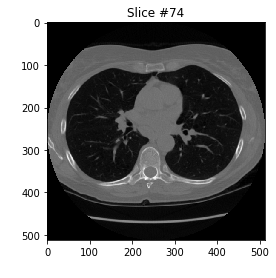

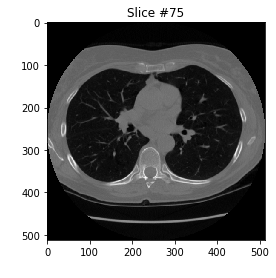

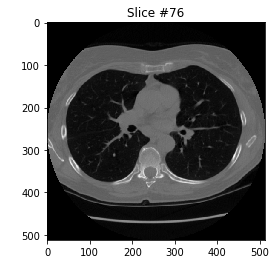

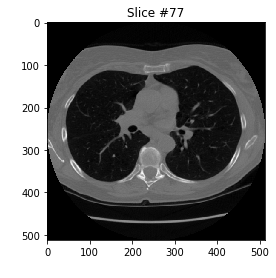

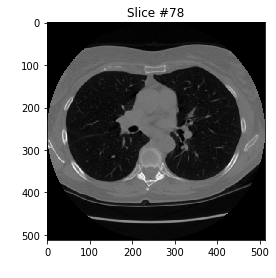

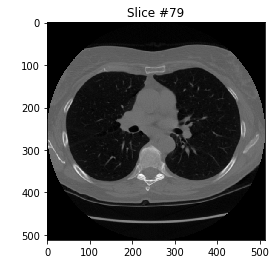

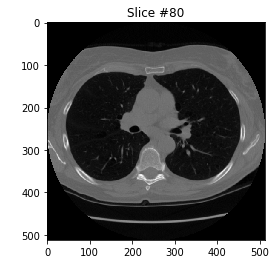

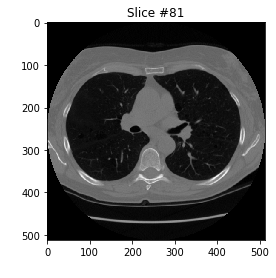

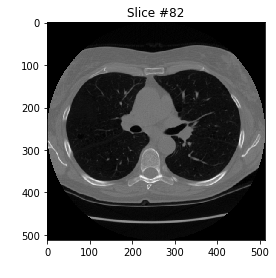

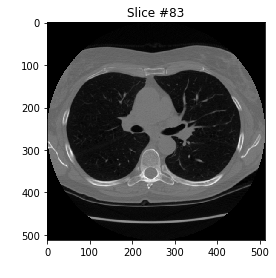

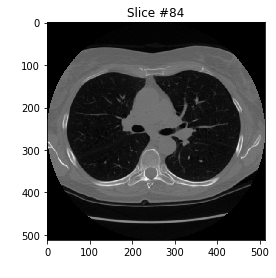

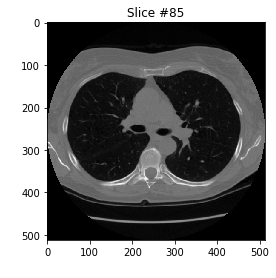

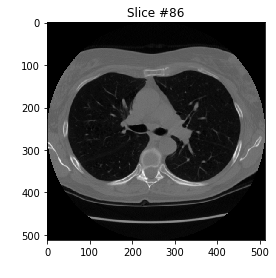

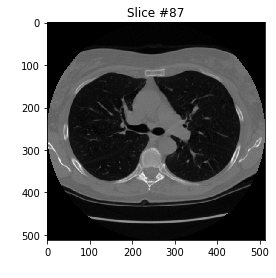

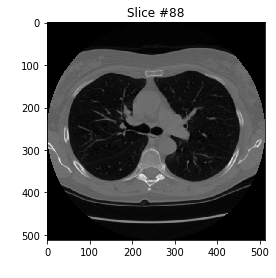

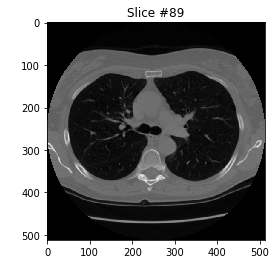

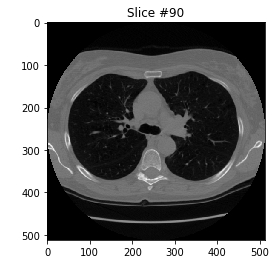

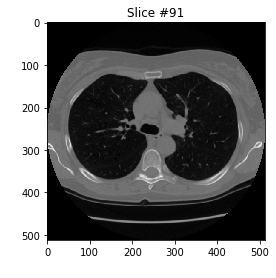

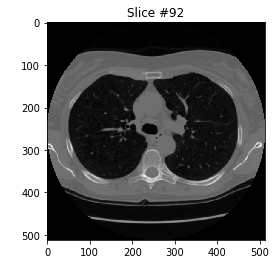

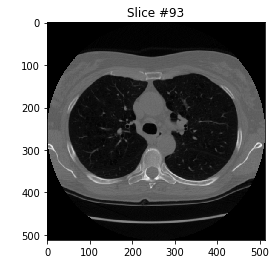

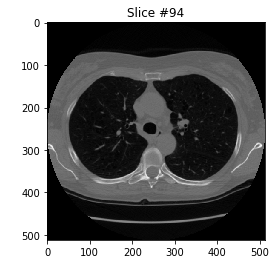

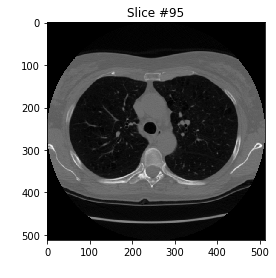

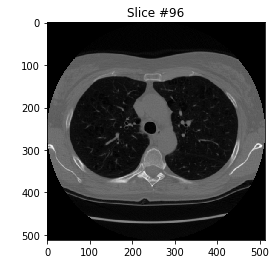

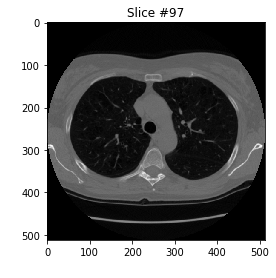

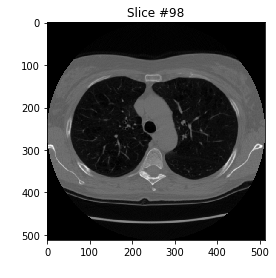

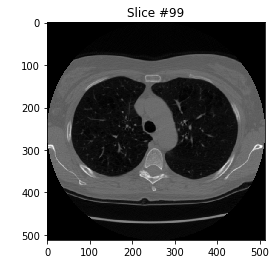

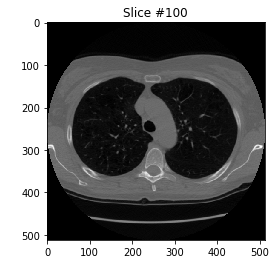

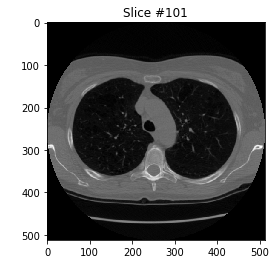

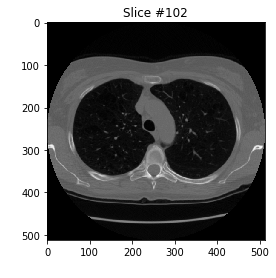

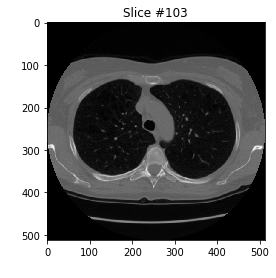

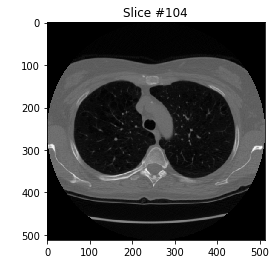

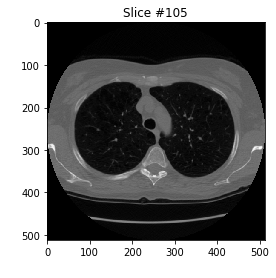

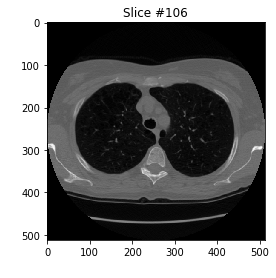

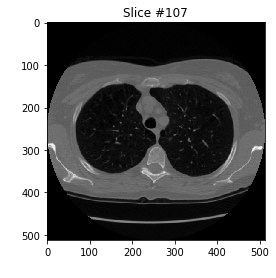

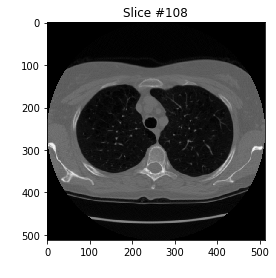

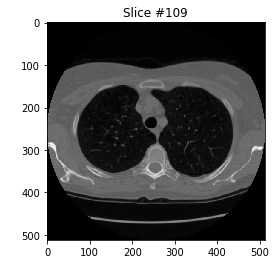

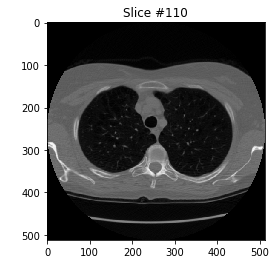

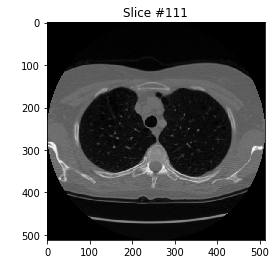

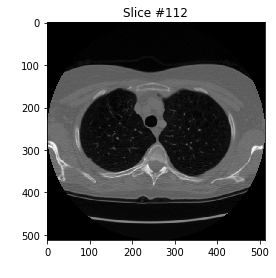

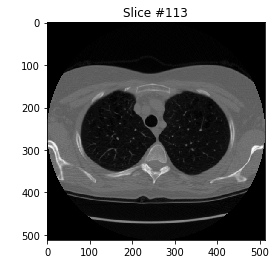

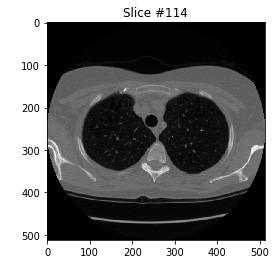

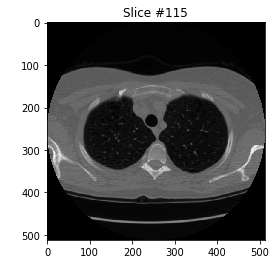

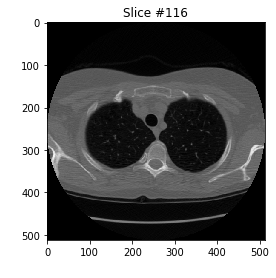

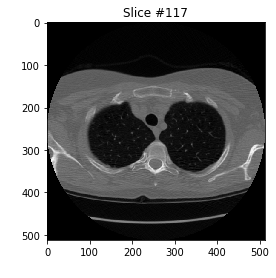

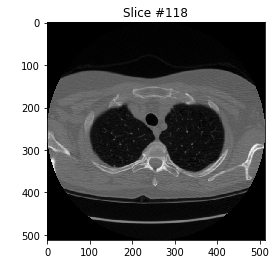

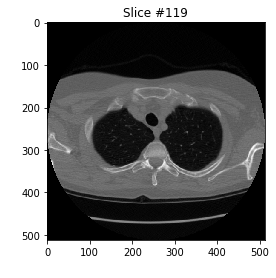

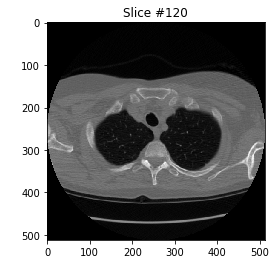

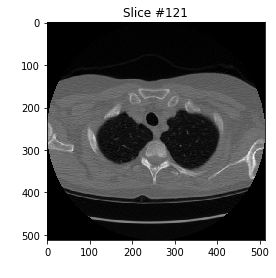

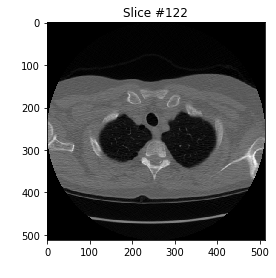

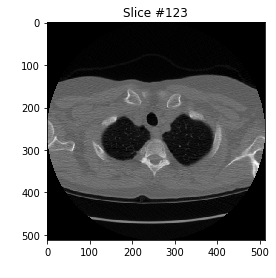

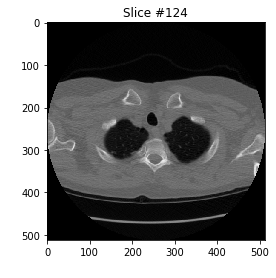

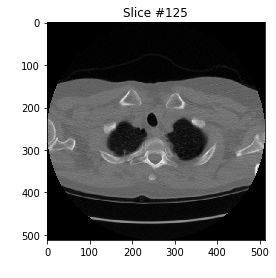

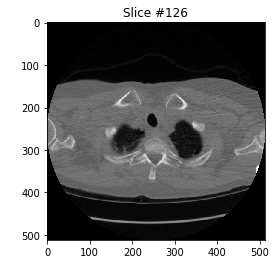

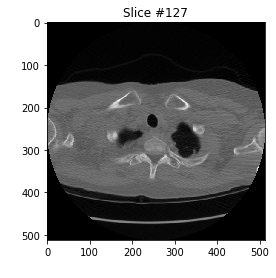

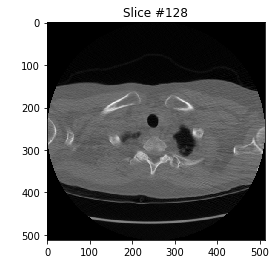

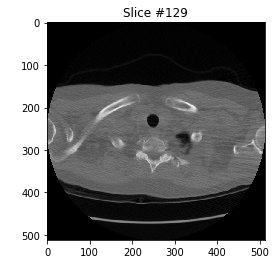

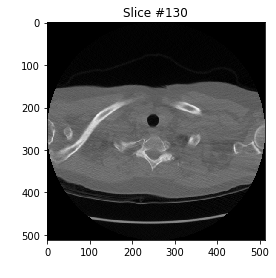

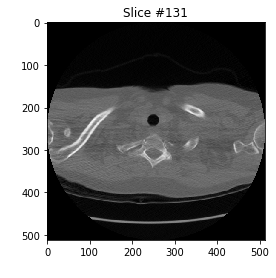

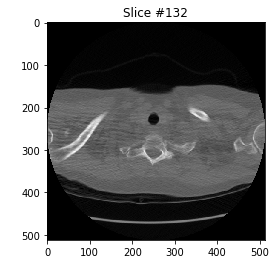

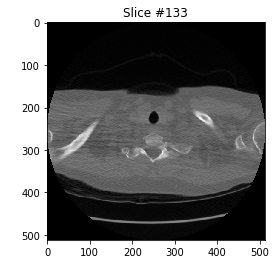

Histogramma HU:


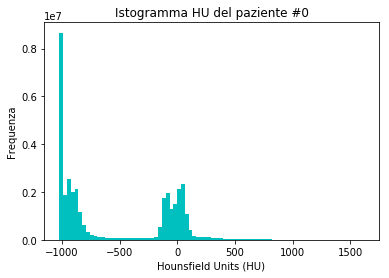

In [5]:
numero_paziente = 0
print("Paziente #", numero_paziente, ":")
time.sleep(1)

stringa_paziente = str(numero_paziente)
primo_paziente = carica_scan(cartella_input + pazienti[numero_paziente])
primo_paziente_pixels = conversione_hu(primo_paziente) #converto in HU


for i in range(500):
    try:
        plt.clf()
        numero_slice = i
        stringa_slice = str(numero_slice)
        plt.imshow(primo_paziente_pixels[numero_slice], cmap=plt.cm.gray)
        plt.title("Slice #" + stringa_slice)
        plt.xlabel(" ")
        plt.ylabel(" ")
        plt.show()
        plt.clf() 
    except:
        pass

print("Histogramma HU:")
time.sleep(1)

plt.hist(primo_paziente_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequenza") #Quato è frequente questo valore HU
plt.title("Istogramma HU del paziente #" + stringa_paziente)
plt.show()

Guardando i valori in tabella possiamo vedere dall'istogramma **quali valori sono aria e quali tessuto**.

## UNIFORMAZIONE DEL *Pixel_spacing*

Uno scan può avere una spaziatura (.PixelSpacing) tra i pixel di `[2.5, 0.5, 0.5]`, cioè la distanza tra le slice è di $2.5 mm$. Per un diverso paziente questa potrebbe essere `[1.5, 0.725, 0.725]`. Per rendere uniformi tutti i dataset dei pazienti si è deciso di ricampionare tutti i dati con la medesima risoluzione ($1mm$\*$1mm$*$1mm$), per possibili future analisi.

In [9]:
def resample(image, scan, nuovo_spacing=[1,1,1]): 
    #pixel spacing è la grandezza del pixel x e y. Devo aggiungere z, ovvero s.SliceThickness
    
    #Determino l'attuale .PixelSpacing
    spacing_lista = [scan[0].SliceThickness]
    spacing_lista.extend(scan[0].PixelSpacing)
    spacing = np.array(spacing_lista, dtype=np.float32) #quindi ora ho [z, x, y]

    resize_factor = spacing / nuovo_spacing 
    #nuovo_spacing l'ho definito nell'argomento della funzione come [1,1,1]
    #print("spacing: ",spacing, "nuovo_spacing: ", nuovo_spacing, ". resize_factor: ", resize_factor)
    nuova_real_shape = image.shape * resize_factor 
    #image.shape è la dimensione di un array tridimensionale con z,x,y
    #print( "image.shape: ", image.shape,"nuova_real_shape: ",nuova_real_shape)
    nuova_shape = np.round(nuova_real_shape)
    #print("nuova_shape (rounded): ", nuova_shape)
    real_resize_factor = nuova_shape / image.shape
    #print("real_resize_factor: ", real_resize_factor)
    nuovo_spacing = spacing / real_resize_factor #dovrebbe essere [1,1,1], è così in tutti icasi
    print("Nuovo_spacing: [", nuovo_spacing[0], ",", nuovo_spacing[1], ",", nuovo_spacing[2], "]")
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest') 
    #faccio l'interpolazione dell'immagine per adattarmi alla nuova shape dell'ndarray
    #lento
    return image, nuovo_spacing

pix_resampled, spacing = resample(primo_paziente_pixels, primo_paziente, [1,1,1])
print(" ")
print("Shape prima del ricampionamento: ", primo_paziente_pixels.shape) 
print("Shape dopo il ricampionamento: ", pix_resampled.shape) #la shape della nuova immagine interpolata

Nuovo_spacing: [ 0.9993506228768981 , 1.0 , 1.0 ]
 
Shape prima del ricampionamento:  (171, 512, 512)
Shape dopo il ricampionamento:  (308, 310, 310)


# 3D PLOT

Passiamo ora alla visualizzazione 3D dell'intero scan. Sfortunatamente, l'unico algoritmo implementabile in $Python3$ per la visualizzazione degli scan è *marching cubes*, un algoritmo di computer grafica che permette di estrarre mesh poligonali (triangoli) di una isosuperficie a partire da un campo scalare discreto 3D (*voxel*). 

L'algoritmo richiede un volume e un valore di isosuperficie. Nell'imaging TAC ad esempio HU tra 700 e 3000 rappresentano le ossa. Quindi un esempio di input potrebbe essere 700 per estrarre una mesh per le regioni osse o con densità simili alle ossa.


![mc](mc.png)


In [11]:
def plot_3d(image, level=-300): #-300 è il level di default
    
    # posiziono lo scanner in modo tale da vedere il paziente dall'alto, se no sarebbe il paziente sdraiato (per stack)
    p = image.transpose(2,1,0)
    
    #estraggo isosuperfici 2D da immagini 3D 
    #http://scikit-image.org/docs/dev/auto_examples/edges/plot_marching_cubes.html
    verts, faces = measure.marching_cubes_classic(p, level) 
    #level è il valore in HU, 
    #VERTS, sono le coordinate spaziali per i vertici delle mesh
    #FACES, definisce le facce triangolari tramite gli indici dei vertici. 
    #Questo algoritmo di default fa output di triangoli, quindi ogni faccia ha esattamente 3 indici
    
    fig = plt.figure(figsize= (10, 10) )
    ax = fig.add_subplot(111, projection='3d') #crea gli assi tridimensionali

    #Poly3DCollection è un insieme di poligoni 3D. I vertici devono conteere coordinate 3D
    mesh = Poly3DCollection(verts[faces], alpha=0.70) 
    #verts[faces] per generare un set di triangoli come di default, alpha è la trasparenza
    face_color = [0.5, 0.5, 0.5] #grigio
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0]) #da zero a quanto è lungo il primo asse di p
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

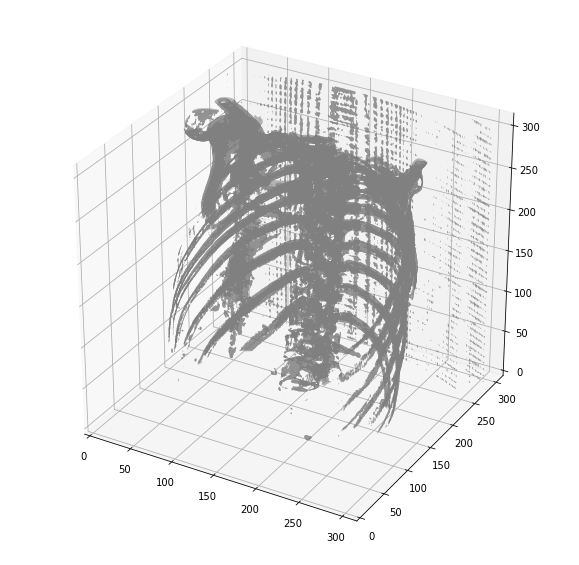

In [12]:
plot_3d(pix_resampled, 400) #plot con level HU 400

# SEGMENTAZIONE DEI POLMONI

Per ridurre lo spazio di lavoro (e quindi il tempo computazionale), si possono segmentare i polmoni.

I passaggi sono:  

* Fisso la soglia dell'immagine (-320 HU è una buona soglia);
* Trovo le componenti connesse, determino il label di aria attorno al paziente, riempio con degli 1 nell'immagine binaria;
* Per ogni slice assiale nello scan determino la componente solida connessa più grande (il corpo + l'aria attorno al paziente), e setto le altri componenti a 0. Questo riempie le strutture nei polmoni;
* Tengo solo il volume di aria più grande (il corpo umano ha piccoli volumi di aria diversi punti).


<pre><span></span><span class="mi">1</span><span class="o">-</span><span class="n">connectivity</span>      <span class="mi">2</span><span class="o">-</span><span class="n">connectivity</span>     

     <span class="p">[</span> <span class="p">]</span>           <span class="p">[</span> <span class="p">]</span>  <span class="p">[</span> <span class="p">]</span>  <span class="p">[</span> <span class="p">]</span>         
     
      <span class="o">|</span>               \  <span class="o">|</span>  <span class="o">/</span>           
      
<span class="p">[</span> <span class="p">]</span><span class="o">--</span><span class="p">[</span><span class="n">x</span><span class="p">]</span><span class="o">--</span><span class="p">[</span> <span class="p">]</span>      <span class="p">[</span> <span class="p">]</span><span class="o">--</span><span class="p">[</span><span class="n">x</span><span class="p">]</span><span class="o">--</span><span class="p">[</span> <span class="p">]</span>    

      <span class="o">|</span>               <span class="o">/</span>  <span class="o">|</span>  \         
      
     <span class="p">[</span> <span class="p">]</span>           <span class="p">[</span> <span class="p">]</span>  <span class="p">[</span> <span class="p">]</span>  <span class="p">[</span> <span class="p">]</span>
</pre>


In [ ]:
def def_volume_max(imm, bg=0):
    vals, conteggi = np.unique(imm, return_counts=True)
    #np.unique ritorna in maniera ordinata gli elementi unici di un array 
    #return_conteggi ritorna il numero di volte in cui ogni valore unico compare nell'array 
    conteggi = conteggi[vals != bg] #i conteggi dove i valori sono diversi dal bg 
    vals = vals[vals != bg] #uguale

    if len(conteggi) > 0:
        return vals[np.argmax(conteggi)] #ritorna il valore più frequente
    else:
        return None

def segmenta_polmoni(image, fill_lung_structures = True):
    
    binary_image = np.array(image > -320, dtype=np.int8) + 1  #ho un array di 1 (dove è <-320) e 2 (dove è >-320)
    #questa soglia è per discriminare l'aria dal resto
    
    
    labels = measure.label(binary_image, connectivity=None) #PER ELIMINARE L'ARIA ATTORNO AL PAZIENTE
    # Se connectivity=None, una piena connectivity di input.ndim è usata (3D in questo caso)
    #ritorna labels: è un Labeled array, in cui a tutte le regioni connesse viene assegnato lo stesso valore intero
    
    #Prendo il pixel nell'angolo per determinare quale label è aria
    background_label = labels[0,0,0] #label in posizione [0,0,0]
    
    #Definisco il label aria
    binary_image[background_label == labels] = 2
    #riempio il label aria con 2 (sostituisco 1 con 2)
    #ORA GLI 1 SONO SOLO I POLMONI
    
    
    # Metodo per riempire le strutture nei polmoni
    if fill_lung_structures:
        #per ogni slice determino la più grande struttura solida
        for i, axial_slice in enumerate(binary_image): #per ogni slice nel vettore binary_image
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = def_volume_max(labeling, bg=0)
            
            if l_max is not None: #Se questa slice contiene i polmoni
                binary_image[i][labeling != l_max] = 1 #riempio le strutture diverse dal massimo
                #quindi RIEMPIO I BRONCHI

    
    binary_image -= 1 #rendo l'immagine veramente binaria togliendo a tutto 1, i polmoni erano 1 ora sono 0
    binary_image = 1 - binary_image # la inverto, i polmoni sono 1
    #il background (il label di aria che era 2) ora è 0
    
    # rimuovo gli altri volumetti d'aria
    labels = measure.label(binary_image, background=0)
    l_max = def_volume_max(labels, bg=0)
    if l_max is not None: # ci sono volumetti d'aria
        binary_image[labels != l_max] = 0 #metto a 0 i volumetti d'aria più piccoli dei polmoni
 
    return binary_image


#applico la funzione segmenta_polmoni al seti di immagini pix_resampled
polmoni = segmenta_polmoni(pix_resampled, False) 
polmoni_fill = segmenta_polmoni(pix_resampled, True)

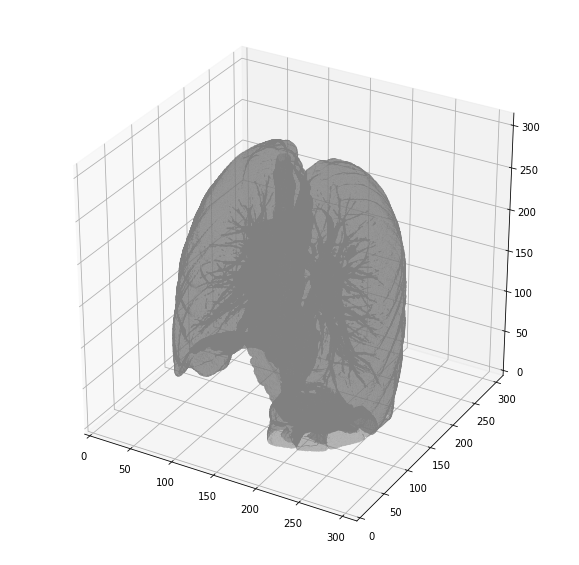

In [116]:
plot_3d(polmoni, 0) #Plot solo della sezione 'polmoni'. Polmoni e bronchi 0 è per plottare una immagine binaria

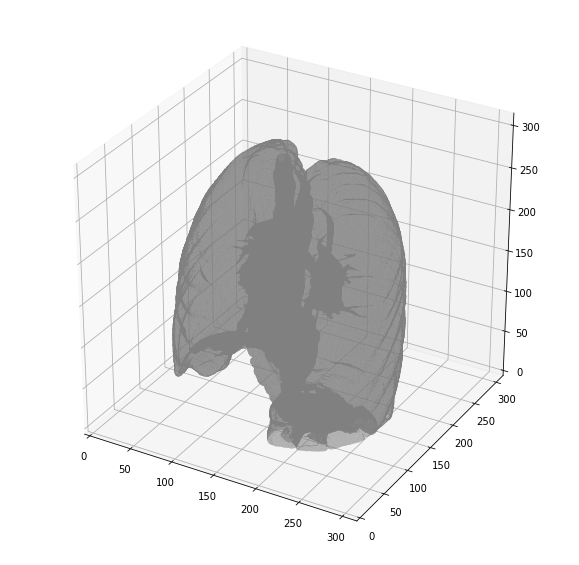

In [15]:
 plot_3d(polmoni_fill, 0) #Solo polmoni

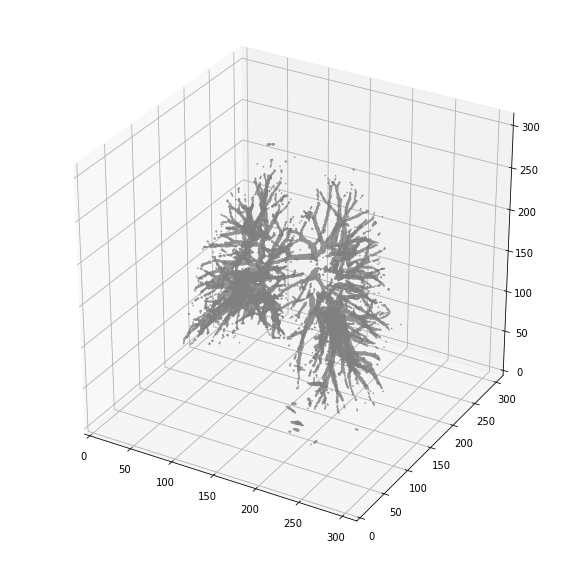

In [111]:
plot_3d(polmoni_fill - polmoni, 0) #Solo bronchi

## BIBLIOGRAFIA

* Dataset messo a disposizione da: *Kaggle, your home for Data Science* , https://www.kaggle.com/
* De Nunzio G, Tommasi E, Agrusti A, Cataldo R, De Mitri I, Favetta M. Automatic lung segmentation in ct images with accurate handling of the hilar region. J Digit Imaging. 2011;24(1):11–27. doi: 10.1007/s10278-009-9229-1
* Lorensen, W. E.; Cline, Harvey E. (1987). "Marching cubes: A high resolution 3d surface construction algorithm". ACM Computer Graphics. 21 (4): 163–169.
* Jones E, Oliphant E, Peterson P, et al. SciPy: Open Source Scientific Tools for Python, 2001-, http://www.scipy.org/ 
* Travis E, Oliphant. A guide to NumPy, USA: Trelgol Publishing, (2006).
* Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53
* John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55
* Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python, PeerJ 2:e453 (2014)
* Lamba R, McGahan JP, Corwin MT (2014) CT Hounsfield numbers of soft tissues on unenhanced abdominal CT scans: variability between two different manufacturers’ MDCT scanners. AJR 203:1013–1020
* Guido Zuidhof, Full Preprocessing, 2017